# Import Libraries

In [4]:
import os
import csv 
import math
import joblib
import pickle
import warnings
import copy
from tqdm import tqdm

import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

warnings.filterwarnings('ignore')

# Splitting Data

## Concate data padel with target

In [ ]:
# Import data from csv into pandas DataFrame
dfPadel = pd.read_csv("data/padel_desc.csv")
dtRawIC50 = pd.read_csv("data/pIC50_target.csv")
dtIC50 = dtRawIC50['pIC50']

# Concatenate data dataframe (Padel,Cdk,Target)
df = pd.concat([dfPadel,dtIC50], axis=1)
df = df.drop(columns = ['Name'])

# Export concatenated data
# df.to_csv (r'data\all_data.csv',index=False, header=True,sep=',')

## Split Train & Test + PCC Correlation

In [ ]:
# Loop for finding correlation combination
for i in range(10):
    # Divide into training data and test data
    dfTrain = df.sample(frac=0.8,random_state=i)
    dfTest = df.drop(dfTrain.index)

    # Find 100 descriptors with strongest correlation with pIC50
    train_corr = dfTrain.corr()
    train_corr = train_corr.iloc[:-1,[-1]]
    train_corr.sort_values("pIC50", ascending = False, inplace = True)
    train_corr = train_corr.iloc[:100,:]

    # Check for WTPT-3 only
    if train_corr.index[0] == "WTPT-3":
        print("i: %04d"%i)
        # Dump training and test data
        dfTrain.to_pickle("./pickle/train_%04d.pkl"%i)
        dfTest.to_pickle("./pickle/test_%04d.pkl"%i)
        # Dump correlation data
        train_corr.to_csv(r'data/dataCorr_%04d.pkl.csv'%i, index= None, header = True)
        # Dump list of 100 strongest des
        corr_100 = train_corr.index.values.tolist()[:100]
        with open('./pickle/corr100_%04d.pkl'%i, 'wb') as f:
            pickle.dump(corr_100, f)

# Feature Selection : SA

## SA Functions

In [2]:
def acceptanceProbability (bestMSE, newMSE, temp , K):
        # If the new solution is worse, calculate an acceptance probability
        return np.exp( K * (newMSE - bestMSE) / temp)
    
def calcMSE(combDesc, x_train, x_val, y_train, y_val, model):
    x_train_slice = x_train.iloc[:,combDesc]
    x_val_slice = x_val.iloc[:,combDesc]
    
    scaler = MinMaxScaler()
    scaler.fit(x_train_slice)
    scale_x_train = scaler.transform(x_train_slice)
    scale_x_val = scaler.transform(x_val_slice)
    
    model.fit(scale_x_train, y_train)
    y_pred = model.predict(scale_x_val)
    return mean_squared_error(y_val, y_pred)

## SA Prepare Data

In [3]:
corrs = []
cor1 = joblib.load('./p/0003/corr100_0003.pkl')
cor2 = joblib.load('./p/0005/corr100_0005.pkl')
cor3 = joblib.load('./p/0006/corr100_0006.pkl')
cor4 = joblib.load('./p/0007/corr100_0007.pkl')
cor5 = joblib.load('./p/0008/corr100_0008.pkl')

trains = []
tr1 = joblib.load('./p/0003/train_0003.pkl')
tr2 = joblib.load('./p/0005/train_0005.pkl')
tr3 = joblib.load('./p/0006/train_0006.pkl')
tr4 = joblib.load('./p/0007/train_0007.pkl')
tr5 = joblib.load('./p/0008/train_0008.pkl')

            #    0,    1,    2,   3,     4
corrs.extend([cor1, cor2, cor3, cor4, cor5])
            #    0,   1,   2,  3,    4
trains.extend([tr1, tr2, tr3, tr4, tr5])

#change index for data
corr_100 = corrs[2]
dft = trains[2]

train = dft.loc[:,corr_100]
train["pIC50"] = dft.iloc[:, -1]
descName = train.columns.values

trained, val = train_test_split(train, test_size = 0.2, random_state = 45)

x_train = trained.iloc[:,:-1]
x_val = val.iloc[:,:-1]
y_train = trained.iloc[:, [-1]]
y_val = val.iloc[:,[-1]]

model = LinearRegression()
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((59, 100), (15, 100), (59, 1), (15, 1))

## SA algorithm

In [4]:
### 50 ITERATION
combos = [5,10,15,20,25]

for k in tqdm(range(5)):

    ## INTO DE SA DE LA'SOIN MODDED ##
    descNum = combos[k]
    descMSE_descNum = []

    for j in tqdm(range(20)):
        # Initialize Values
        initTemp, temp = 100, 100
        tempEnd = 0.1
        cooling_rate = 0.98
        iteration = 50

        # Simulated Annealing
        bestList = []
        bestMSEList = []
        tempChange = []

        # Initialize solution & Best MSE (Random descNum descriptor)
        bestSol = np.random.choice(x_train.shape[1],descNum, replace=False)
        bestSol = list(bestSol)
        bestSol.sort()

        # First MSE
        bestMSE = calcMSE(bestSol, x_train, x_val, y_train, y_val, model)
        while temp > tempEnd:
            for i in range(iteration):

                # Create new solution & new MSE
                newSol = np.random.choice(x_train.shape[1], descNum, replace=False)
                newMSE = calcMSE(newSol, x_train, x_val, y_train, y_val, model)
                
                # New solution is better based on MSE value
                if newMSE < bestMSE :
                    bestMSE = newMSE
                    bestSol = newSol
                    #bestList.append([bestMSE,bestSol])
                    #tempChange.append(temp)
                    #bestMSEList.append(bestMSE)
                    
                #Probability to accept bad solution
                else :
                    deltaMSE = newMSE - bestMSE
                    K = (initTemp * np.log(0.8)) / deltaMSE
                    
                    if acceptanceProbability (bestMSE, newMSE, temp , K) > np.random.rand(1,1):
                        bestMSE = newMSE
                        bestSol = newSol
                        #bestList.append([bestMSE,bestSol])
                        #tempChange.append(temp)
                        #bestMSEList.append(bestMSE)
            
            bestList.append([bestMSE,bestSol])
            tempChange.append(temp)
            bestMSEList.append(bestMSE)
            temp *= cooling_rate

        descMSE_descNum.append([bestList[-1][0],bestList[-1][1],bestMSEList,tempChange])
       
    # Extracting results
    df_SA = pd.DataFrame(descMSE_descNum)
    df_SA.columns=["MSE","solution","growth", "temp"]
    df_SA.reset_index(drop=True, inplace= True)

    # Sort values
    df_SA_sort = df_SA.copy()
    df_SA_sort.sort_values('MSE', inplace=True)

    # Get Descriptors name    
    bestDescriptor = []
    for i in df_SA_sort.iloc[0,1]:
        bestDescriptor.append(descName[i])

    df_SA.to_pickle(f"./p/0006_n1/raw_0006_{combos[k]}.pkl")
    joblib.dump(bestDescriptor, f"./p/0006_n1/best_0006_{combos[k]}.pkl")

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:23:58<00:00, 1727.77s/it]


## Plot MSE

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 626.76it/s]


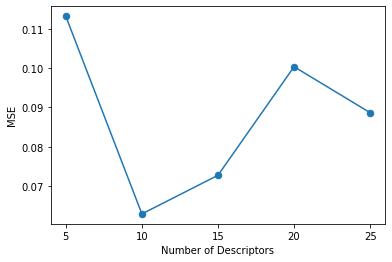

In [39]:
# MSE Plot
bd_list = []
bd_5 = joblib.load('./p/0005_n1/raw_0005_5.pkl')
bd_10 = joblib.load('./p/0005_n1/raw_0005_10.pkl')
bd_15 = joblib.load('./p/0005_n1/raw_0005_15.pkl')
bd_20 = joblib.load('./p/0005_n1/raw_0005_20.pkl')
bd_25 = joblib.load('./p/0005_n1/raw_0005_25.pkl')
bd_list.extend([bd_5,bd_10,bd_15,bd_20,bd_25])

list_MSE = []
df_mse = pd.DataFrame(columns=['desc','mse'])
x = [5,10,15,20,25]

for i in tqdm(range(len(bd_list))):
    bd_list[i].sort_values('MSE', inplace = True)
    list_MSE.append(bd_list[i].iloc[0,0])
    
    
df_mse['desc'] = [5,10,15,20,25]
df_mse['mse'] = list_MSE

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.set_xticks(x)

plt.plot(x, df_mse['mse'], marker='.' ,markersize=13)
plt.xlabel('Number of Descriptors')
plt.ylabel('MSE')
plt.show()

# Model Development : SVR

## Preparing Data

In [41]:
# Load train and test data
# IMPORTANT! LOOK AT THE LOADED FILES
train = joblib.load('./p/0005/train_0005.pkl', 'rb')
test = joblib.load('./p/0005/test_0005.pkl', 'rb')

# Create params for kernels
param_rbf={
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['auto','scale'],
            'epsilon':[0.1, 1, 10, 100, 1000]
}

param_linear={
            'C': [0.1, 1, 10, 100, 1000],
            'degree': [1],
            'epsilon':[0.1, 1, 10, 100, 1000]
}

param_poly={
            'C': [0.1, 1, 10, 100, 1000],
            'degree': [2, 3, 4, 5],
            'epsilon':[0.1, 1, 10, 100, 1000]
}

# Create list of descriptors set
# IMPORTANT! MUST BE SAME AS LOADED TRAIN & TEST
bd_list = []
bd_5 = joblib.load('./p/0005_n1/best_0005_5.pkl')
bd_10 = joblib.load('./p/0005_n1/best_0005_10.pkl')
bd_15 = joblib.load('./p/0005_n1/best_0005_15.pkl')
bd_20 = joblib.load('./p/0005_n1/best_0005_20.pkl')
bd_25 = joblib.load('./p/0005_n1/best_0005_25.pkl')
bd_list.extend([bd_5,bd_10,bd_15,bd_20,bd_25])

## SVR : RBF 

In [42]:
r2_rbf = pd.DataFrame(columns=['desc','C','Gamma','Epsilon','r2_train','r2_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=param_rbf,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_gamma = gsc.best_params_['gamma']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="rbf", gamma=param_gamma, epsilon=param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    r2_rbf = r2_rbf.append(pd.Series([len(bd_list[i]),param_c, param_gamma, param_epsilon, r2_train, r2_test, y_train_pred, y_test_pred], index=r2_rbf.columns ), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


In [44]:
# joblib.dump(r2_rbf, './p/0006_n1/r2_rbf_neue.pkl')
# r2_rbf = joblib.load('./p/0006_n1/r2_rbf_neue.pkl')
r2_rbf

,desc,C,Gamma,Epsilon,r2_train,r2_test,train_pred,test_pred
0,5,1000,auto,0.1,0.751894,0.377799,"[5.827186180474718, 7.856057101914479, 6.57926...","[7.302132616199009, 7.3888874472227775, 6.2624..."
1,10,10,scale,0.1,0.837593,0.613808,"[5.985624391199954, 7.645372868075312, 6.42641...","[7.495874873384412, 7.510310994075349, 6.19338..."
2,15,10,auto,0.1,0.663377,0.598002,"[6.302944985403234, 7.548903790191631, 6.13629...","[7.185570264673777, 7.206626710753887, 6.63806..."
3,20,100,auto,0.1,0.759090,0.710471,"[6.208832532474693, 7.7756258986612234, 6.2036...","[7.185798978858633, 7.2548772273576585, 6.5620..."
4,25,100,scale,0.1,0.988589,0.451543,"[5.785980410531562, 7.6447084102149025, 6.9861...","[7.1861869697092935, 7.1075732837020045, 6.248..."


## SVR : Linear

In [45]:
r2_linear = pd.DataFrame(columns=['desc','C','degree','epsilon','r2_train','r2_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid=param_linear,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_degree = gsc.best_params_['degree']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="linear", degree=param_degree, epsilon = param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    r2_linear = r2_linear.append(pd.Series([len(bd_list[i]),param_c, param_degree, param_epsilon, r2_train, r2_test, y_train_pred, y_test_pred], index=r2_linear.columns ), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


In [46]:
# joblib.dump(r2_linear, './p/0006_n1/r2_linear_neue.pkl')
# r2_linear = joblib.load('./p/0006_n1/r2_linear_neue.pkl')
r2_linear

,desc,C,degree,epsilon,r2_train,r2_test,train_pred,test_pred
0,5,1000,1,0.1,0.604945,0.536981,"[6.259761696723191, 7.6457058977787, 6.0926125...","[6.829682979845276, 6.928030798153233, 6.48318..."
1,10,10,1,0.1,0.621871,0.653866,"[6.721584325244292, 7.472024477267512, 5.95159...","[7.18625327264993, 7.2353437921706405, 6.78776..."
2,15,1,1,0.1,0.599082,0.630382,"[6.405686544835811, 7.270317222160819, 6.23408...","[7.100932613800058, 7.12864574158182, 6.758558..."
3,20,10,1,0.1,0.702875,0.720793,"[6.448982217617401, 7.469576577232419, 6.12942...","[6.986247841957694, 7.0553569905006865, 6.5665..."
4,25,1,1,0.1,0.641173,0.695201,"[6.409187755525373, 7.355248922951276, 6.48488...","[6.881053435334151, 6.6861115412409795, 6.7151..."


## SVR : Polynomial 

In [15]:
r2_poly = pd.DataFrame(columns=['desc','C','degree','epsilon','r2_train','r2_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='poly'),
        param_grid=param_poly,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_degree = gsc.best_params_['degree']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="poly", degree=param_degree, epsilon = param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    r2_poly = r2_poly.append(pd.Series([len(bd_list[i]),param_c, param_degree, param_epsilon, r2_train, r2_test, y_train_pred, y_test_pred], index=r2_poly.columns ), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:37<00:00, 163.57s/it]


In [16]:
joblib.dump(r2_poly, './p/0006_n1/r2_poly_neue.pkl')
r2_poly = joblib.load('./p/0006_n1/r2_poly_neue.pkl')
r2_poly

,desc,C,degree,epsilon,r2_train,r2_test,train_pred,test_pred
0,5,10,2,0.1,0.582809,0.162610,"[6.531045840089309, 6.973571295585268, 6.38081...","[6.494664176091527, 6.557542804540136, 7.18718..."
1,10,10,2,0.1,0.700945,0.589258,"[6.752899286772264, 7.503277921782187, 6.20928...","[5.989362202787996, 6.589583404870568, 7.26747..."
2,15,10,2,0.1,0.706295,0.606288,"[6.844743465703837, 7.265331034581643, 6.15495...","[6.136925050668766, 6.652900817703867, 7.13042..."
3,20,10,2,0.1,0.650787,0.512330,"[6.809105555664954, 7.521422452352884, 6.12990...","[6.42426701445098, 6.635527475777221, 7.245611..."
4,25,1,2,0.1,0.662759,0.411443,"[6.78127975139056, 7.384957631542009, 6.121682...","[6.475526264158646, 6.340372378485958, 7.07009..."


## R2 Plots for Model Development

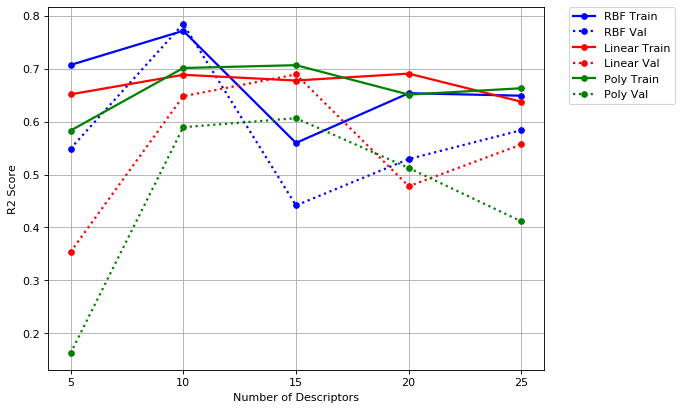

In [24]:
### plot
# x = np.arange(5,26,5)
x = [5,10,15,20,25]

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)  # Create a figure and an axes.

ax.plot(x, r2_rbf.loc[:,'r2_train'], label='RBF Train',marker='.',markersize=10, lw=2, color='b')
ax.plot(x, r2_rbf.loc[:,'r2_test'], label='RBF Val', marker='.', markersize=10, lw=2, ls='dotted', color='b') 
ax.plot(x, r2_linear.loc[:,'r2_train'], label='Linear Train', marker='.',markersize=10, lw=2,color='r')
ax.plot(x, r2_linear.loc[:,'r2_test'], label='Linear Val', marker='.', markersize=10, lw=2, ls='dotted',color='r')
ax.plot(x, r2_poly.loc[:,'r2_train'], label='Poly Train', marker='.', markersize=10, lw=2, color='g')
ax.plot(x, r2_poly.loc[:,'r2_test'], label='Poly Val', marker='.', markersize=10, lw=2, ls='dotted', color='g')

ax.set_xlabel('Number of Descriptors')
ax.set_ylabel('R2 Score')
# ax.set_title("SVR r2 score")  
ax.set_xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.savefig('./p/0003/r2_models_numdesc.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

# Model Validation

## Validation Functions

In [126]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2

def q2_looV2(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mse_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mse_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
#     plt.savefig('./app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_rbf(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./graph/rbf_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_lin(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./graph/lin_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_poly(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./graph/poly_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

## Validation : Preparing Data

In [81]:
data = pd.read_csv("data/all_data.csv")

# Use best desc based on r2_score model development
desc = joblib.load('./p/0005_n1/best_0005_10.pkl')

# Important! Use same datasets
df_train = joblib.load('./p/0005/train_0005.pkl')
df_test = joblib.load('./p/0005/test_0005.pkl')

df_train.shape, df_test.shape

((74, 1876), (19, 1876))

## Validation : RBF

### QSAR Param RBF

In [122]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 10,
            'gamma': 'scale',
            'epsilon':0.1
}

c = param_grid['C']
gam = param_grid['gamma']
eps = param_grid['epsilon']

model = SVR(kernel="rbf", C=c, gamma=gam, epsilon=eps)

model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

q2_rbf = q2_loo(model, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_rbf

array([0.59761519])

In [83]:
rbf_val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
rbf_val_train

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.842697,1.044453,0.926964,0.192187,0.035595,0.13196,0.600156,0.193184


In [84]:
rbf_val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))
rbf_val_test

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.634547,0.884778,1.036497,0.005912,0.158927,0.097095,0.514359,0.162643


### CR2p (Y_random) RBF

In [85]:
rp = y_random(model,scale_x_train,y_train)
joblib.dump(rp,'./p/0005_n1/rbf_crp2.pkl')
rp

array([0.63746412])

### Applicability Domain RBF

0.44594594594594594


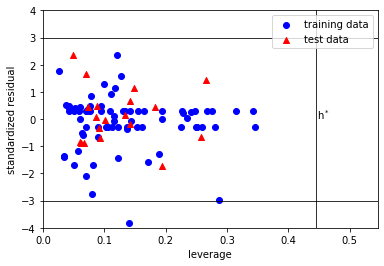

In [127]:
applicability_domain_rbf(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

In [153]:
rbf_valid = pd.DataFrame()
rbf_valid = rbf_valid.append(rbf_val_train)
rbf_valid = rbf_valid.append(rbf_val_test)
rbf_valid.insert(1,'q2', [q2_rbf[0], q2_rbf[0]])
rbf_valid['y_random'] = [rp[0],rp[0]]
rbf_valid.to_csv(r'./p/0005_n1/rbf_val_neue.csv', index= None, header = True)
rbf_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.842697,0.597615,1.044453,0.926964,0.192187,0.035595,0.131960,0.600156,0.193184,0.637464
0,0.634547,0.597615,0.884778,1.036497,0.005912,0.158927,0.097095,0.514359,0.162643,0.637464


<!-- ## Validation : Linear -->

## Validation : Linear

### QSAR Param Linear

In [158]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 10,
            'degree': 1,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_lin = SVR(kernel="linear", C= c, degree= deg, epsilon=eps)

model_lin.fit(scale_x_train, y_train)
y_train_pred = model_lin.predict(scale_x_train)
y_test_pred = model_lin.predict(scale_x_test)

q2_lin = q2_loo(model_lin, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_lin

array([0.54826769])

In [159]:
lin_val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
lin_val_train

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.622942,1.115858,0.828736,0.606308,0.017721,0.366655,0.398796,0.317389


In [156]:
lin_val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))
lin_val_test

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.701601,1.048975,0.865025,0.16234,0.001247,0.113023,0.572834,0.21603


### CR2p (Y_random) Linear

In [157]:
rp_lin = y_random(model_lin,scale_x_train,y_train)
joblib.dump(rp_lin,'./p/0005_n1/lin_crp2.pkl')
rp_lin

array([0.58614356])

### Applicability Domain Linear

0.44594594594594594


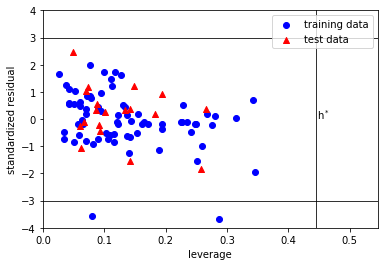

In [133]:
applicability_domain_lin(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

In [150]:
lin_valid = pd.DataFrame()
lin_valid = lin_valid.append(lin_val_train)
lin_valid = lin_valid.append(lin_val_test)
lin_valid.insert(1,'q2', [q2_lin[0], q2_lin[0]])
lin_valid['y_random'] = [rp_lin[0],rp_lin[0]]
lin_valid.to_csv(r'./p/0005_n1/lin_val_neue.csv', index= None, header = True)
lin_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.622942,0.548268,1.115858,0.828736,0.606308,0.017721,0.366655,0.398796,0.317389,0.58591
0,0.701601,0.548268,1.048975,0.865025,0.162340,0.001247,0.113023,0.572834,0.216030,0.58591


## Validation : Polynomial

### QSAR Param Poly

In [160]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 10,
            'degree': 2,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_pol = SVR(kernel="poly", C= c, degree= deg, epsilon=eps)
model_pol.fit(scale_x_train,y_train)
y_train_pred = model_pol.predict(scale_x_train)
y_test_pred = model_pol.predict(scale_x_test)

q2_poly = q2_loo(model_pol, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_poly

array([0.62519427])

In [161]:
poly_val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
poly_val_train

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.687312,1.216075,0.743107,0.950778,0.090635,0.591187,0.323734,0.384065


In [162]:
poly_val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))
poly_val_test

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.597547,1.024331,0.835418,0.401259,0.003273,0.237815,0.438036,0.266173


### CR2p (Y_random) Poly

In [163]:
rp_poly = y_random(model_pol,scale_x_train,y_train)
joblib.dump(rp_poly, './p/0005_n1/poly_cr2p')
rp_poly

array([0.61321928])

### Applicability Domain Poly

In [167]:
poly_valid = pd.DataFrame()
poly_valid = poly_valid.append(poly_val_train)
poly_valid = poly_valid.append(poly_val_test)
poly_valid.insert(1,'q2', [q2_poly[0], q2_poly[0]])
poly_valid['y_random'] = [rp_poly[0],rp_poly[0]]
poly_valid.to_csv(r'./p/0005_n1/poly_val_neue.csv', index= None, header = True)
poly_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.687312,0.625194,1.216075,0.743107,0.950778,0.090635,0.591187,0.323734,0.384065,0.613219
0,0.597547,0.625194,1.024331,0.835418,0.401259,0.003273,0.237815,0.438036,0.266173,0.613219


# Graphs

## Preparing data

In [20]:
# data = pd.read_csv("data/all_data.csv")

desc = joblib.load('./p/0005_n1/best_0005_10.pkl')
desc_raw = joblib.load('./p/0005_n1/raw_0005_10.pkl')
df_train = joblib.load('./p/0005/train_0005.pkl')
df_test = joblib.load('./p/0005/test_0005.pkl')

pic = pd.read_csv("data/pIC50_target.csv")
df_pic = pic['pIC50']

ytrain =  df_train.iloc[:,[-1]]
ytest =  df_test.iloc[:,[-1]]

## Plot Temperature Vs. Mse

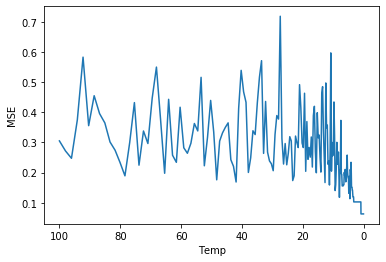

In [184]:
df = desc_raw.copy()
df.sort_values('MSE', inplace = True)

temp = df.iloc[0,3]
growth = df.iloc[0,2]

fig = plt.figure()
plt.plot(temp, growth)
plt.xlabel('Temp')
plt.ylabel('MSE')
# plt.ylim(0.1, 0.55)
plt.xlim(105,-5)
plt.savefig('./graph/growth_mse_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot MSE Vs. Num of Desc

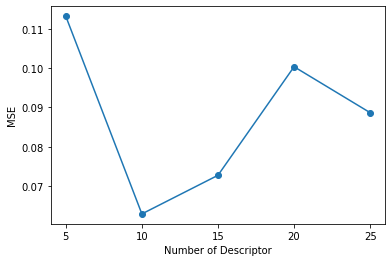

In [25]:
bd_list = []
bd_5 = joblib.load('./p/0005_n1/raw_0005_5.pkl')
bd_10 = joblib.load('./p/0005_n1/raw_0005_10.pkl')
bd_15 = joblib.load('./p/0005_n1/raw_0005_15.pkl')
bd_20 = joblib.load('./p/0005_n1/raw_0005_20.pkl')
bd_25 = joblib.load('./p/0005_n1/raw_0005_25.pkl')
bd_list.extend([bd_5,bd_10,bd_15,bd_20,bd_25])

list_MSE = []
x=[5,10,15,20,25]
df_mse = pd.DataFrame(columns=['desc','mse'])

for i in range(len(bd_list)):
    bd_list[i].sort_values('MSE', inplace = True)
    list_MSE.append(bd_list[i].iloc[0,0])
     
df_mse['desc'] = [5,10,15,20,25]
df_mse['mse'] = list_MSE

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.set_xticks(x)

plt.xlabel('Number of Descriptor')
plt.ylabel('MSE')
plt.plot(x, df_mse['mse'], marker='.' ,markersize=12)
# plt.savefig('./graph/mse_numdesc_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Histogram pIC50

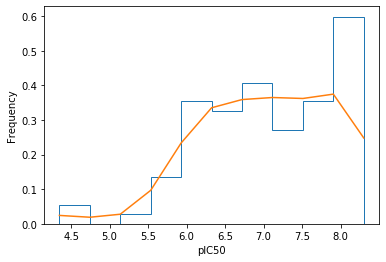

In [16]:
import scipy.stats as stats

df_target = pd.read_csv("data/pIC50_target.csv")

targets = df_target.iloc[:,1]

noise = targets
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, bins=10, histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.savefig('./graph/hist_pic50.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

## Histogram MSE choosen desc

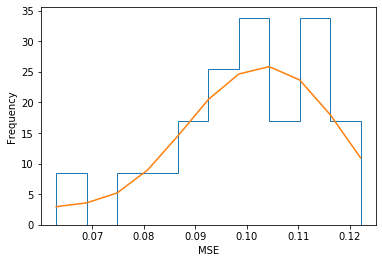

In [17]:
df = desc_raw.copy()
mse_temp = df.iloc[:,0]

noise = mse_temp
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, bins=10, histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.savefig('./graph/hist_mse_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For RBF

In [209]:
param_grid={
            'C': 10,
            'gamma': 'scale',
            'epsilon':0.1
}
c = param_grid['C']
gam = param_grid['gamma']
eps = param_grid['epsilon']

model = SVR(kernel="rbf", C= c, gamma= gam, epsilon=eps)
model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred


### Actual Vs. Predict

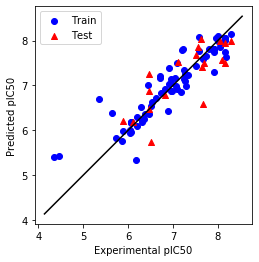

In [210]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./graph/actpred_rbf_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

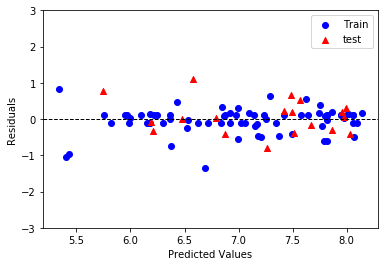

In [211]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./graph/res_rbf_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For Linear

In [213]:
param_grid={
            'C': 10,
            'degree': 1,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_lin = SVR(kernel="linear", C= c, degree= deg, epsilon=eps)
model_lin.fit(scale_x_train, y_train)
y_train_pred = model_lin.predict(scale_x_train)
y_test_pred = model_lin.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred

### Actual Vs. Predict

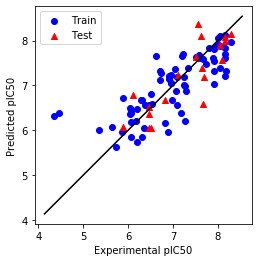

In [214]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./graph/actpred_linear_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

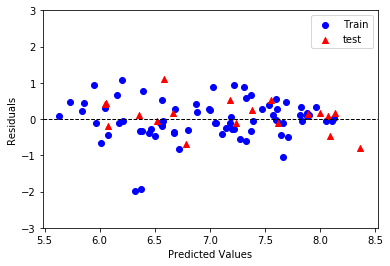

In [215]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./graph/res_linear_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For Poly

In [216]:
param_grid={
            'C': 10,
            'degree': 2,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

modelPol = SVR(kernel="poly", C= c, degree= deg, epsilon=eps)
modelPol.fit(scale_x_train, y_train)
y_train_pred = modelPol.predict(scale_x_train)
y_test_pred = modelPol.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred

### Actual Vs. Predict

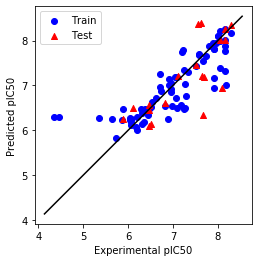

In [219]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./graph/actpred_poly_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

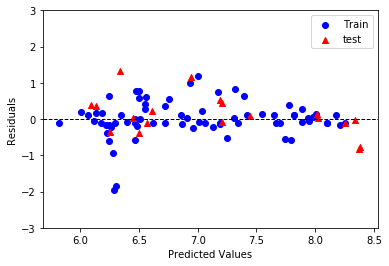

In [220]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./graph/res_poly_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()